1/1 [==============================] - 0s 274ms/step


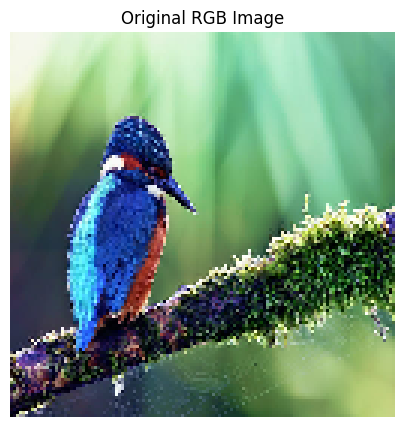

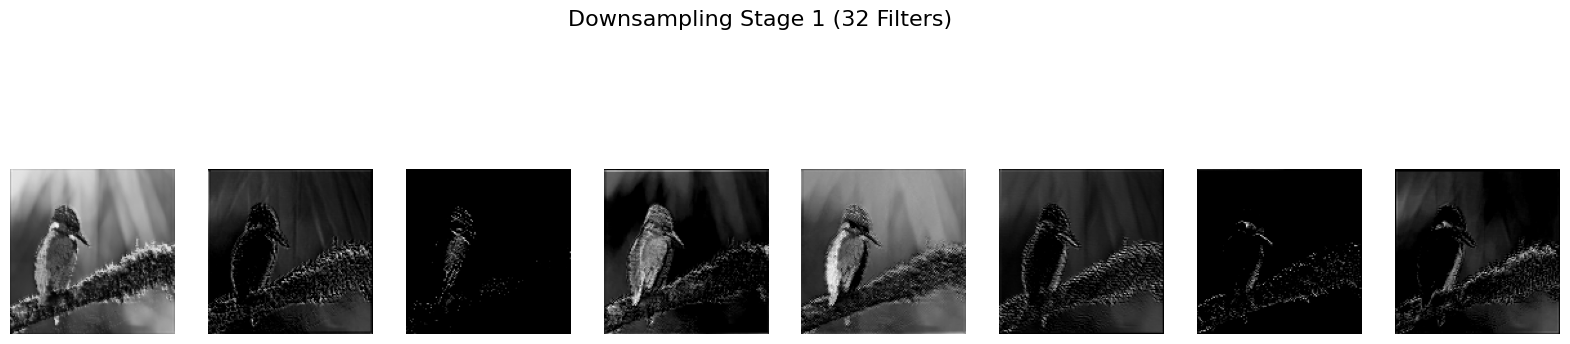

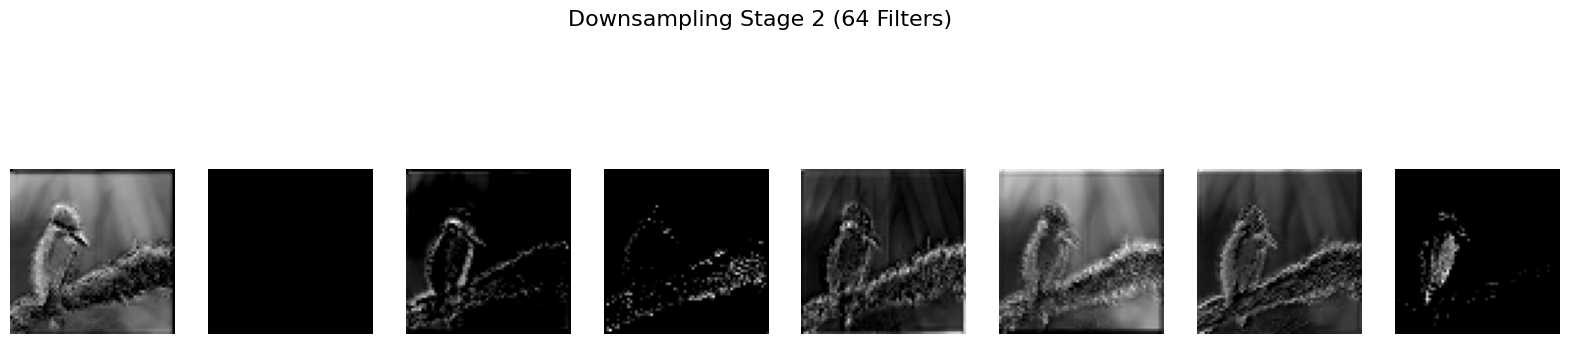

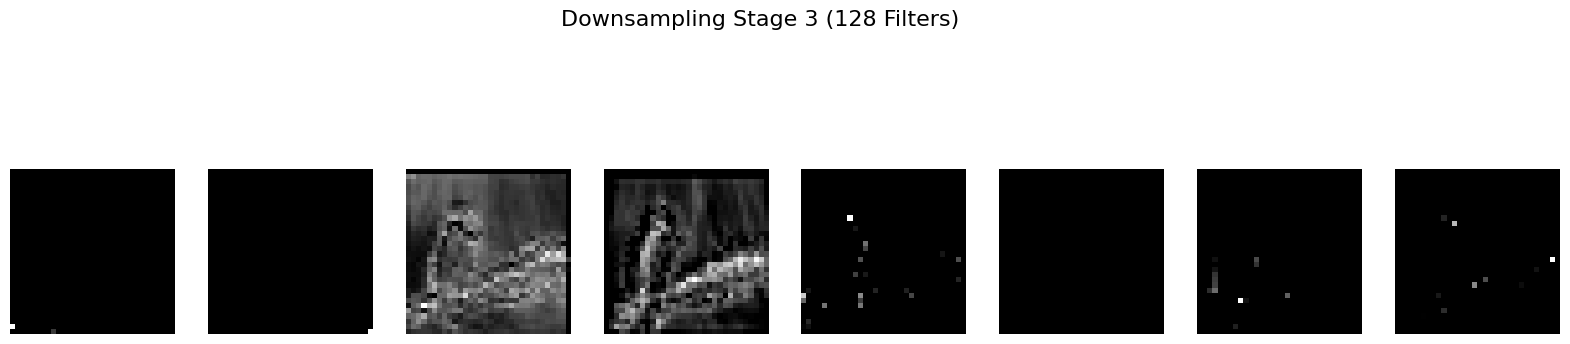

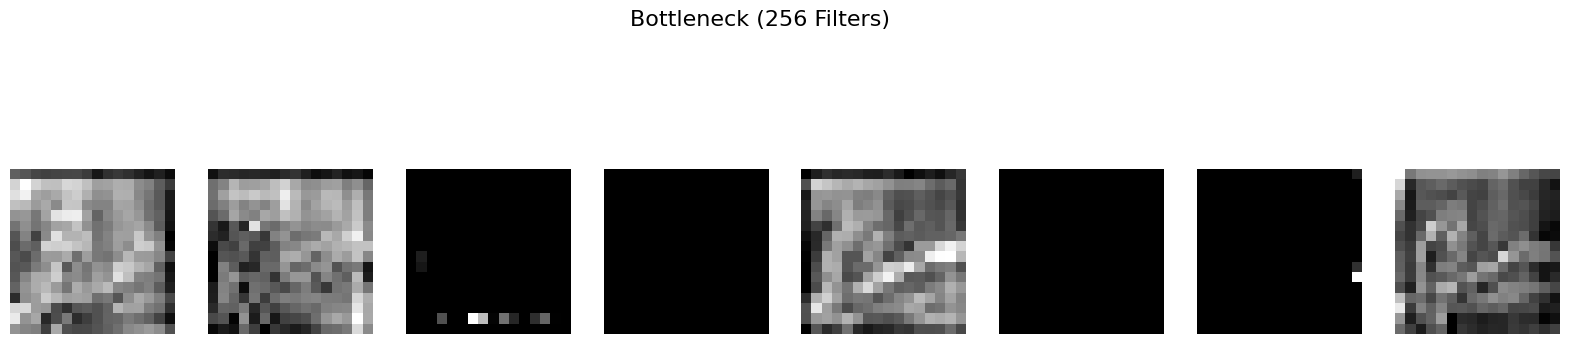

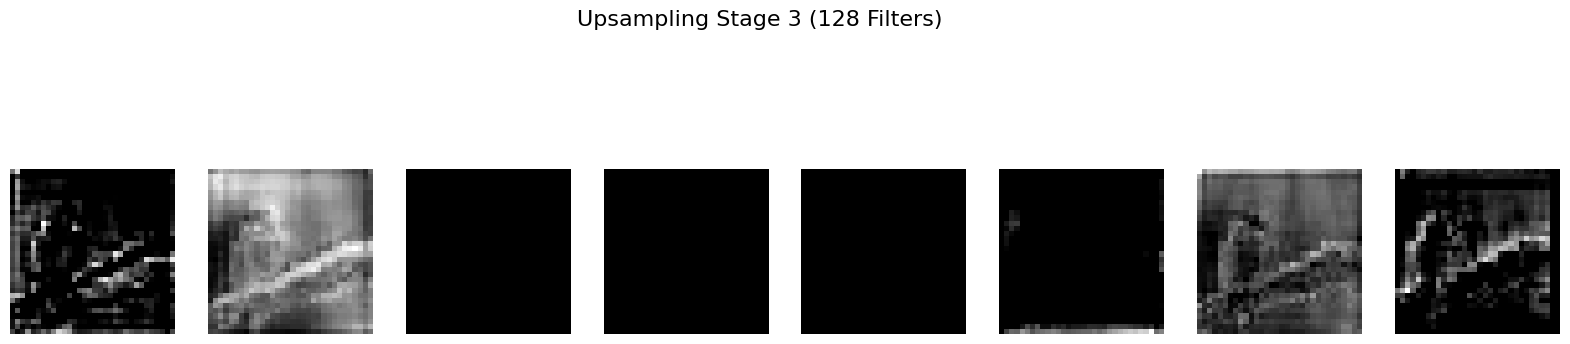

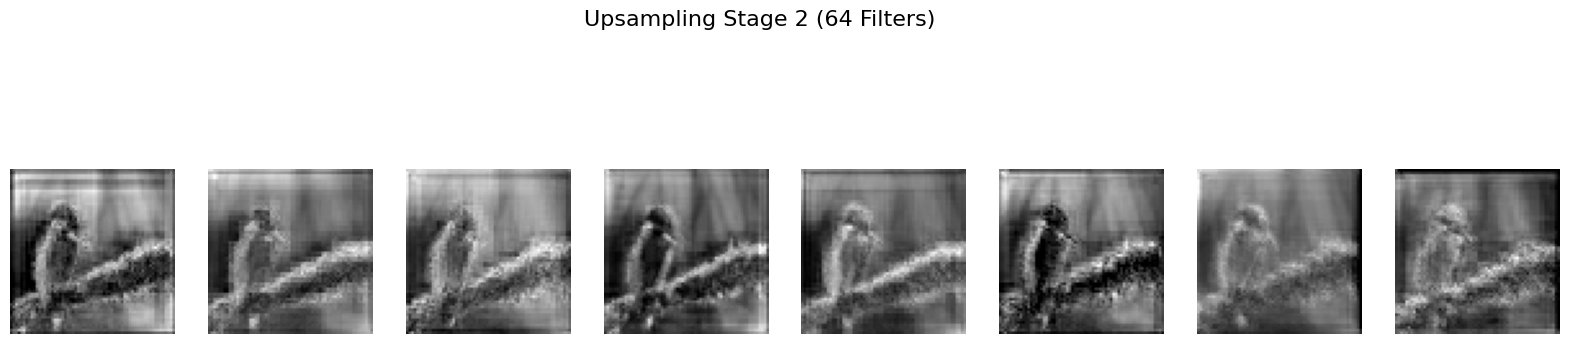

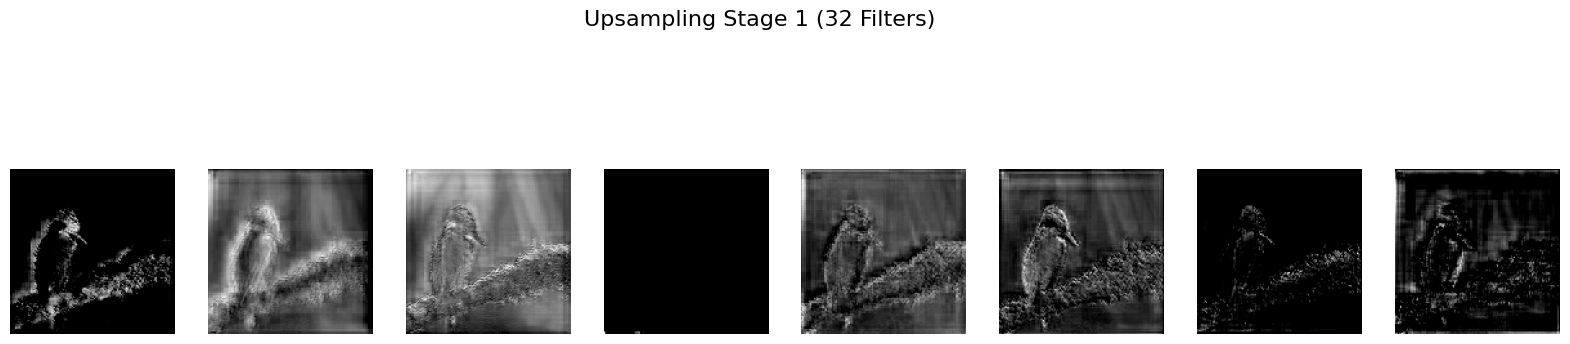

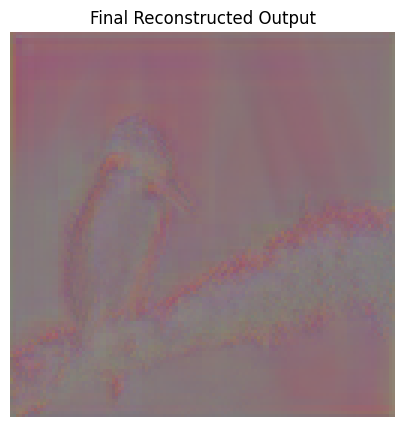

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Add, Concatenate
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import tensorflow as tf

# Function to define a residual block
def residual_block(input_tensor, filters, kernel_size=(3, 3), strides=(1, 1)):
    x = Conv2D(filters, kernel_size, strides=strides, padding='same', activation='relu')(input_tensor)
    x = Conv2D(filters, kernel_size, strides=strides, padding='same', activation=None)(x)
    shortcut = Conv2D(filters, (1, 1), strides=strides, padding='same')(input_tensor)
    x = Add()([x, shortcut])
    x = tf.keras.layers.ReLU()(x)
    return x

# U-Net Architecture
def unet_model(input_shape):
    inputs = Input(shape=input_shape)

    # Encoder (Downsampling)
    conv1 = residual_block(inputs, 32)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = residual_block(pool1, 64)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = residual_block(pool2, 128)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    bottleneck = residual_block(pool3, 256)

    # Decoder (Upsampling)
    upconv3 = UpSampling2D(size=(2, 2))(bottleneck)
    concat3 = Concatenate()([upconv3, conv3])
    deconv3 = residual_block(concat3, 128)

    upconv2 = UpSampling2D(size=(2, 2))(deconv3)
    concat2 = Concatenate()([upconv2, conv2])
    deconv2 = residual_block(concat2, 64)

    upconv1 = UpSampling2D(size=(2, 2))(deconv2)
    concat1 = Concatenate()([upconv1, conv1])
    deconv1 = residual_block(concat1, 32)

    outputs = Conv2D(3, (1, 1), activation='sigmoid')(deconv1)

    # Create the U-Net model
    model = Model(inputs=inputs, outputs=[conv1, conv2, conv3, bottleneck, deconv3, deconv2, deconv1, outputs])
    return model

# Load and preprocess the RGB image
img_path = '/home/icmr/Pictures/BIRD.jpg'  # Replace with your image path
original_img = load_img(img_path, target_size=(128, 128))
img_array = img_to_array(original_img) / 255.0  # Normalize pixel values to [0, 1]
input_img = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Define the U-Net model
input_shape = (128, 128, 3)
model = unet_model(input_shape)

# Get feature maps from the U-Net
feature_maps = model.predict(input_img)

# Unpack feature maps
down1, down2, down3, bottleneck, up3, up2, up1, final_output = feature_maps

# Function to visualize feature maps
def visualize_feature_maps(feature_maps, title, num_filters=8):
    num_filters = min(num_filters, feature_maps.shape[-1])  # Limit the number of filters to display
    plt.figure(figsize=(20, 5))
    for i in range(num_filters):
        plt.subplot(1, num_filters, i + 1)
        plt.imshow(feature_maps[0, :, :, i], cmap='gray')
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.show()

# Display original RGB image
plt.figure(figsize=(5, 5))
plt.imshow(original_img)
plt.title('Original RGB Image')
plt.axis('off')
plt.show()

# Visualize feature maps at each stage
visualize_feature_maps(down1, "Downsampling Stage 1 (32 Filters)")
visualize_feature_maps(down2, "Downsampling Stage 2 (64 Filters)")
visualize_feature_maps(down3, "Downsampling Stage 3 (128 Filters)")
visualize_feature_maps(bottleneck, "Bottleneck (256 Filters)")
visualize_feature_maps(up3, "Upsampling Stage 3 (128 Filters)")
visualize_feature_maps(up2, "Upsampling Stage 2 (64 Filters)")
visualize_feature_maps(up1, "Upsampling Stage 1 (32 Filters)")

# Display final output
plt.figure(figsize=(5, 5))
plt.imshow(final_output[0])  # Display the reconstructed output
plt.title('Final Reconstructed Output')
plt.axis('off')
plt.show()
